In [55]:
import json
import warnings
import nltk
import umap.umap_ as umap
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm.notebook import tqdm
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# File paths
file_path = "arxiv-metadata-oai-snapshot.json"
output_file_path = "cleaned_lemmatized_abstracts.txt"

# Setup
stop_words = set(word.lower() for word in stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Data holders
filtered_tokens_all = []
list_of_abstract_token_lists = []
abstract_count = 0
max_abstracts = 10000

# Open file to write cleaned abstracts
with open(output_file_path, "w", encoding="utf-8") as output_file:
    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            if abstract_count >= max_abstracts:
                break
            try:
                json_object = json.loads(line)
                if "abstract" in json_object and json_object["abstract"].strip():
                    abstract = json_object["abstract"]

                    # Tokenize
                    tokens = word_tokenize(abstract)

                    # Clean and lemmatize
                    filtered = [
                        lemmatizer.lemmatize(word.lower(), pos='n')
                        for word in tokens
                        if word.isalpha() and word.lower() not in stop_words
                    ]

                    if filtered:
                        # Add to data holders
                        filtered_tokens_all.extend(filtered)
                        list_of_abstract_token_lists.append(filtered)
                        abstract_count += 1

                        # Write to file (one line per abstract)
                        output_file.write(" ".join(filtered) + "\n")

            except json.JSONDecodeError:
                continue

# Create DataFrame (summary of all tokens)
df_filtered = pd.DataFrame({
    'filtered_word_tokens': [filtered_tokens_all],
    'combined_abstract_cleaned': [" ".join(filtered_tokens_all)]
})

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Darsh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Darsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Darsh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
# Uses the new file created which contains the cleaned and lemmatized abstracts
cleaned_file_path = "cleaned_lemmatized_abstracts.txt"

word_freq = Counter()

with open(cleaned_file_path, "r", encoding="utf-8") as file:
    for line in file:
        tokens = line.strip().split()
        word_freq.update(tokens)

# Shows the most common words
print("\nTop 50 most common words:")
for word, count in word_freq.most_common(50):
    print(f"{word}: {count}")


Top 50 most common words:
model: 5064
result: 3731
field: 3464
system: 3290
show: 3213
state: 2802
also: 2708
two: 2616
energy: 2602
using: 2438
theory: 2424
function: 2418
study: 2399
mass: 2331
quantum: 2291
one: 2136
present: 2032
data: 2017
star: 1998
equation: 1880
case: 1856
time: 1833
method: 1811
effect: 1776
paper: 1769
find: 1716
density: 1710
structure: 1709
phase: 1690
new: 1670
space: 1656
galaxy: 1656
property: 1642
parameter: 1640
distribution: 1588
number: 1557
order: 1536
solution: 1524
magnetic: 1481
large: 1444
temperature: 1439
spectrum: 1426
problem: 1393
different: 1387
based: 1350
observed: 1313
group: 1303
analysis: 1286
first: 1282
term: 1257


In [42]:
## NOTE: ONLY RUN THIS SECTION IF NEEDED SINCE IT TAKES A WHILE
# TF-IDF Vectorization
cleaned_abstracts = []
with open(cleaned_file_path, "r", encoding="utf-8") as file:
    for line in file:
        cleaned_abstracts.append(line.strip())
        
tfidf_vec = TfidfVectorizer(max_features=5000, min_df = 5)
tfidf_mat = tfidf_vec.fit_transform(cleaned_abstracts)

# BERT (This runs for approx 5min)
def get_bert(text, batch_size=64):
    # Load pre-trained model and tokenizer
    # Using Distil Bert Tokenizer since it is much faster than regular Bert Tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertModel.from_pretrained('distilbert-base-uncased')

    # Process in batches
    embeddings = []
    for i in tqdm(range(0, len(text), batch_size)):
        start = i
        end = start + batch_size
        batch_text = text[start:end]

        device = torch.device('cpu')
        model = model.to(device)


        # Tokenizing 
        tokenized_text = tokenizer(batch_text, padding=True, truncation=True, max_length=512, return_tensors='pt')
        for key, val in tokenized_text.items():
            tokenized_text[key] = val.to(device)

        # Get Embeddings
        with torch.no_grad():
            output = model(**tokenized_text)

        # Update embeddings list
        embeddings.append(output.last_hidden_state[:, 0, :].numpy())

    # Cleanup Embeddings
    embeddings = np.vstack(embeddings)
    print("Embeddings: ")
    print(embeddings)
    return embeddings


bert_embedd = get_bert(cleaned_abstracts)

  0%|          | 0/157 [00:00<?, ?it/s]

Embedding Shape: 
[[-0.3909954  -0.09850162 -0.23021983 ... -0.23009214  0.3081151
   0.11001076]
 [-0.31533834  0.05468257 -0.11013706 ... -0.19449955  0.3255644
   0.01272166]
 [-0.38865402 -0.0182808   0.05760095 ... -0.24178764  0.3533068
   0.22058795]
 ...
 [-0.54164934 -0.07462857 -0.22608589 ... -0.19731006  0.07098331
   0.2753523 ]
 [-0.29436946 -0.17887843 -0.38277417 ... -0.04080689  0.10667791
   0.23228352]
 [-0.510643   -0.25334337 -0.1033466  ... -0.27798966  0.1183402
   0.4721526 ]]


In [50]:
# Dimensionality Reduction

# Ignoring a few warnings being given
warnings.filterwarnings("ignore", category=FutureWarning)

# Variables
n_components = 2
perplexity = 30 # reduce when using more than 10,000 datasets
dence_tfidf_matrix = tfidf_mat.toarray() if hasattr(tfidf_mat, 'toarray') else tfidf_mat

# PCA with tfidf_matrix and bert
pca = PCA(n_components=n_components)
pca_tfidf = pca.fit_transform(dence_tfidf_matrix)
pca_bert = pca.fit_transform(bert_embedd)

# TSNE with tfidf_matrix and bert
tsne = TSNE(n_components=n_components, perplexity=perplexity, max_iter=1000, random_state=42)
tsne_tfidf = tsne.fit_transform(dence_tfidf_matrix)
tsne_bert = tsne.fit_transform(bert_embedd)

# UMAP with tfidf_matrix and bert
u_map = umap.UMAP(n_components=n_components, random_state=42)
umap_tfidf = u_map.fit_transform(dence_tfidf_matrix)
umap_bert = u_map.fit_transform(bert_embedd)

C:\Users\Darsh\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Darsh\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Darsh\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [58]:
# Compare Representation Quality using Clustering
def evaluate_performance(embedding, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    fit_predicted_kmeans = kmeans.fit_predict(embedding)

    silhouette_sc = silhouette_score(embedding, fit_predicted_kmeans)
    davies_bouldin_sc = davies_bouldin_score(embedding, fit_predicted_kmeans)
    calinski_harabasz_sc = calinski_harabasz_score(embedding, fit_predicted_kmeans)

    return silhouette_sc, davies_bouldin_sc, calinski_harabasz_sc

scores = evaluate_performance(pca_tfidf)
print(f"PCA_TFIDF: Silhouette={scores[0]:.4f}, DBI={scores[1]:.4f}, CHI={scores[2]:.4f}")

scores = evaluate_performance(pca_bert)
print(f"PCA_BERT: Silhouette={scores[0]:.4f}, DBI={scores[1]:.4f}, CHI={scores[2]:.4f}")

scores = evaluate_performance(tsne_tfidf)
print(f"TSNE_TFIDF: Silhouette={scores[0]:.4f}, DBI={scores[1]:.4f}, CHI={scores[2]:.4f}")

scores = evaluate_performance(tsne_bert)
print(f"TSNE_BERT: Silhouette={scores[0]:.4f}, DBI={scores[1]:.4f}, CHI={scores[2]:.4f}")

scores = evaluate_performance(umap_tfidf)
print(f"UMAP_TFIDF: Silhouette={scores[0]:.4f}, DBI={scores[1]:.4f}, CHI={scores[2]:.4f}")

scores = evaluate_performance(umap_bert)
print(f"UMAP_BERT: Silhouette={scores[0]:.4f}, DBI={scores[1]:.4f}, CHI={scores[2]:.4f}")

PCA_TFIDF: Silhouette=0.3706, DBI=0.8201, CHI=10343.4284
PCA_BERT: Silhouette=0.3382, DBI=0.9041, CHI=7532.4508
TSNE_TFIDF: Silhouette=0.3840, DBI=0.8172, CHI=9707.3555
TSNE_BERT: Silhouette=0.3915, DBI=0.8292, CHI=11338.7338
UMAP_TFIDF: Silhouette=0.4376, DBI=0.7920, CHI=12447.7028
UMAP_BERT: Silhouette=0.4269, DBI=0.8022, CHI=13727.2780


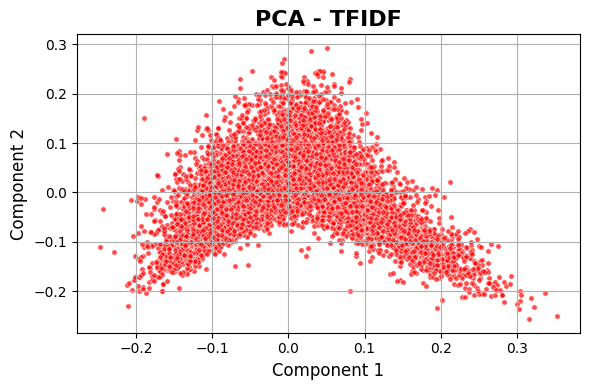

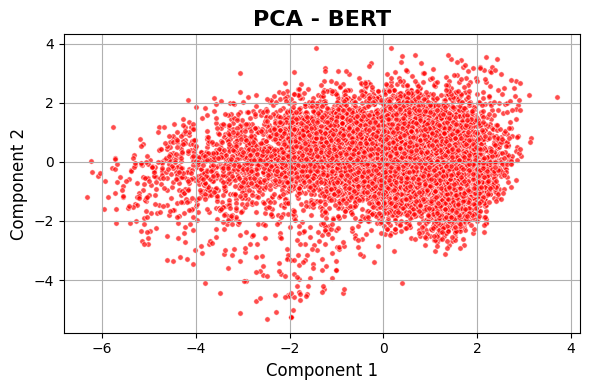

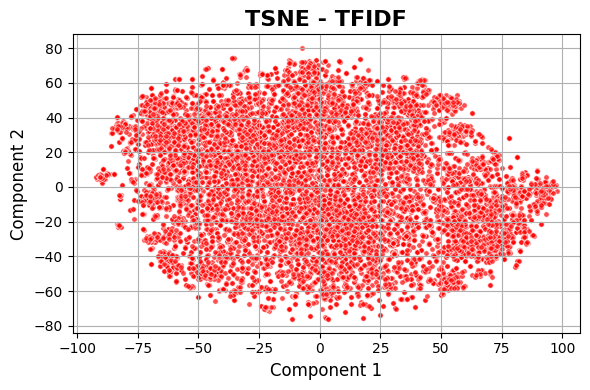

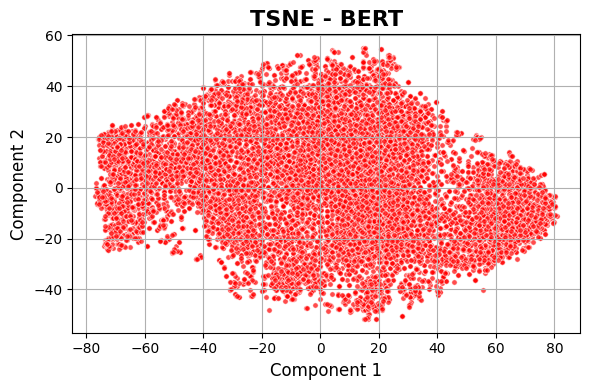

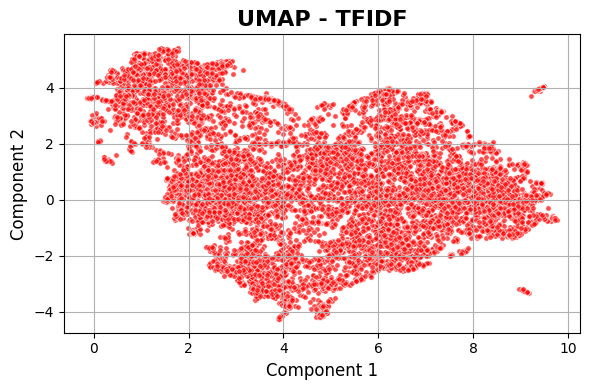

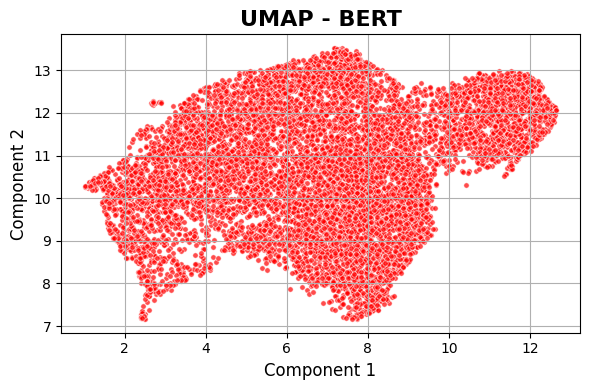

In [69]:
# Visualization of Paper Clusters
def plot_embeddings(embedding, title):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], alpha=0.7, s=15, linewidth=0.5, color='r')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Component 1', fontsize=12)
    plt.ylabel('Component 2', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Visualizing the reduced space
plot_embeddings(pca_tfidf, "PCA - TFIDF")
plot_embeddings(pca_bert, "PCA - BERT")
plot_embeddings(tsne_tfidf, "TSNE - TFIDF")
plot_embeddings(tsne_bert, "TSNE - BERT")
plot_embeddings(umap_tfidf, "UMAP - TFIDF")
plot_embeddings(umap_bert, "UMAP - BERT")